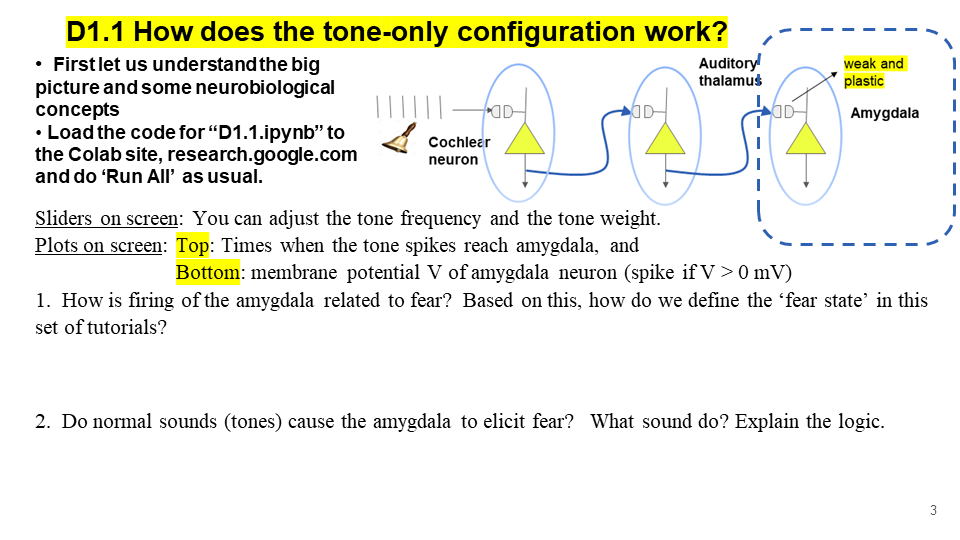

In [1]:
#@title Run cell to activate model
import os
import numpy as np
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min")
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron &>/dev/null
    !pip install ipywidgets==7.7.1 &> /dev/null # installs Neuron
    root = 'Fear-Lesson-Plans'
    folder = 'D1'
    pathlist = normpath(os.getcwd()).split(sep)
    if pathlist[-1] != folder:
      rootidx = pathlist.index(root) if root in pathlist else -1
      if rootidx>0:
        os.chdir(join(sep,*pathlist[:rootidx]))
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git &> /dev/null 
      os.chdir(join(root,folder))
#print(os.getcwd())
os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.

import matplotlib.pyplot as plt
from matplotlib import gridspec
from neuron import h
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline
h.load_file('stdrun.hoc')

h.dt = 0.1 # time step (resolution) of the simulation in ms
h.tstop = 2500 # how long to run the simulation in ms
h.v_init= -65 # initial membrane potential in mV

soma = [h.Section(name='soma[%d]'% i) for i in range(1)] # makes one soma called soma[0]
#print(soma[0].psection())
for i in range(1):
    soma[i].insert("hh")
    soma[i].diam = 30 # micrometers
    soma[i].L = 30 # micrometers
    soma[i].cm = 1 # membrane capacitance uF/cm2
    soma[i].Ra = 25 # ohm-cm
    
#h.topology()

#pyr2pyr0 = h.pyr2pyr(soma[0](0.5))

tone2pyr0 = h.pyr2pyr(soma[0](0.9)) # makes a syn connected to soma

#shock2pyr0 = h.pyr2pyr(soma[0](0.8))


t = h.Vector()      # Vectors are used to record data in the simulation
Soma_v = h.Vector()
#i_nmda = h.Vector()
#capoolcon = h.Vector()
#W = h.Vector()

t.record(h._ref_t)                # derefences and records data
Soma_v.record(soma[0](0.5)._ref_v)
#i_nmda.record(tone2pyr0._ref_inmda)
#capoolcon.record(tone2pyr0._ref_capoolcon)
#W.record(tone2pyr0._ref_W)

def plot_variables(tone_freq): # plots stuff
    
    #fig = plt.figure(figsize=(12,8),tight_layout=True)
    #spec = fig.add_gridspec(3, 2)
    #ax11 = fig.add_subplot(spec[0,0]); ax12 = fig.add_subplot(spec[0,1])
    #ax31 = fig.add_subplot(spec[1,:])
    #ax21 = fig.add_subplot(spec[2,0]); ax22 = fig.add_subplot(spec[2,1])
    
    #gs_kw = dict(width_ratios=[1,1], height_ratios=[2,1,2])
    #fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
    #                              ['middle center','middle center'],
    #                              ['lower left', 'lower right']],
    #                          gridspec_kw=gs_kw, figsize=(12, 8),
    #                          constrained_layout=True)

    fig = plt.figure(figsize=(15, 5),tight_layout=True) 
    gs = gridspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[1,1]) 


    ax0 = plt.subplot(gs[1,:])
    ax2 = plt.subplot(gs[0,:])


    ax0.plot(t, Soma_v)
    ax0.legend(['Soma Vm'])
    ax0.set_ylabel('Voltage (mV)')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylim(-80,50)
    ax0.set_xlim(0,1800)
    
    ax2.set_ylabel('Inputs')
    ax2.set_xlabel("Time (ms)")
    if tone_freq == 0:
        tone = np.arange(3000,4000,1)
    else:
        tone = np.arange(100,1750,1000/tone_freq)
    tone_index = []
    for i in range(len(tone)):
        tone_index.append(1)
    
    ax2.scatter(tone,tone_index,label='Tone')
    if tone_freq == 0:
        major_ticks = np.arange(3000,4000,1)
    else:
        major_ticks = np.arange(100, 1750, 1000/tone_freq)
    y_ticks = np.arange(1,3,1)
    ax2.set_xticks(major_ticks)
    ax2.set_yticks(y_ticks)
    ax2.legend()
    n = 4  # Keeps every 4th tick label
    [l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_ticklabels()) if i % n != 0]
    ax2.grid()
    ax2.set_xlim(0,1800)
    #ax2.set_ylim(0.8,1)
    
    plt.show()

def activemodel(initW_tone, tone):
    weight_tone = initW_tone
    if (weight_tone == 0):
        weight_tone = 0.0000000001
        
    tone_freq = tone
    tone2pyr0.initW = weight_tone
    soma[i].diam = 30
    
    nstim_tone = h.NetStim(0.9) # makes spike trains
    if (tone_freq != 0):
        nstim_tone.interval=(1000/tone_freq) # ms (mean) time between spikes
        nstim_tone.start = 100               # ms (most likely) start time of first spike
    else:
        nstim_tone.interval=0
        nstim_tone.start = 10000            # way to make the tone freq 0 during stim time
    nstim_tone.number = 100                 # (average) number of spikes
    nstim_tone.noise = 0                    # range 0 to 1. Fractional randomness.
    nc_tone = h.NetCon(nstim_tone,tone2pyr0,0,0,1)    # connects tone to soma via tone2pyr syn
    
    
    h.run()
    plt.close('all')
    plot_variables(tone_freq)

initW = 1
diam = 30
tone_freq = 20


w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_initW_tone = widgets.FloatSlider(value=1, min=0, max=5, step=0.2,layout=Layout(width='20%', height='15px'))
w_tone_f = widgets.IntSlider(value=20, min=0, max=80, step=5,layout=w_initW_tone.layout)


def reset_default(*args):
    w_initW_tone.value = initW
    w_tone_f.value = tone_freq
    
w_reset.on_click(reset_default)

labels = ['Tone Freq','Tone Weight']
Labels = [Label(L) for L in labels]

ui = VBox([ HBox([w_reset]),
           HBox([Labels[0],w_tone_f]),
           HBox([Labels[1],w_initW_tone])])
out = interactive_output(activemodel, {'initW_tone':w_initW_tone,'tone':w_tone_f})

display(ui,out)





/usr/bin/xcrun
/Users/gregglickert/Downloads
Mod files:

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    


ld: warning: ignoring duplicate libraries: '-lnrnmech'


Successfully created x86_64/special


AttributeError: 'hoc.HocObject' object has no attribute 'pyr2pyr'